## This notebook holds our fsm and best models with evaluations
### Note: A random seed was not used, if replicated this project, results may slightly vary

In [41]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow_addons as tfa
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings('ignore', category=BadKey)

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.python.keras import datasets, layers, models, regularizers
import tensorflow_addons as tfa
from tensorflow_addons.layers import GroupNormalization

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

import glob
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions

from tensorflow.keras.layers import Input

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

from src import functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

## Baseline Model

In [9]:
train_data, val_data, test_data = fn.load_data_generators()

Found 2568 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 427 images belonging to 2 classes.


In [11]:
model = Sequential()
model.add(Flatten(input_shape=(100,100,1)))
model.add(Dense(units=85, 
                activation='relu'))
model.add(Dense(units=1, 
                activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [12]:
history = model.fit(train_data, 
                    epochs=10, 
                    validation_data=(val_data), 
                    steps_per_epoch=len(train_data), 
                    validation_steps=len(val_data))

Epoch 1/10
81/81 [==============================] - 30s 368ms/step - loss: 0.7964 - accuracy: 0.6269 - precision: 0.6459 - recall: 0.7368 - val_loss: 0.4881 - val_accuracy: 0.7945 - val_precision: 0.7943 - val_recall: 0.9035
Epoch 2/10
81/81 [==============================] - 29s 360ms/step - loss: 0.4819 - accuracy: 0.7749 - precision: 0.7698 - recall: 0.8524 - val_loss: 0.4631 - val_accuracy: 0.8036 - val_precision: 0.9270 - val_recall: 0.7427
Epoch 3/10
81/81 [==============================] - 28s 349ms/step - loss: 0.4109 - accuracy: 0.8162 - precision: 0.8146 - recall: 0.8691 - val_loss: 0.3645 - val_accuracy: 0.8400 - val_precision: 0.8547 - val_recall: 0.8947
Epoch 4/10
81/81 [==============================] - 28s 342ms/step - loss: 0.3727 - accuracy: 0.8380 - precision: 0.8391 - recall: 0.8788 - val_loss: 0.3416 - val_accuracy: 0.8618 - val_precision: 0.8958 - val_recall: 0.8801
Epoch 5/10
81/81 [==============================] - 28s 345ms/step - loss: 0.3780 - accuracy: 0.8252

In [10]:
data_array, class_list = fn.generator_to_array(test_data)

### Evaluating the model on the unseen test data

              precision    recall  f1-score   support

      NORMAL       0.78      0.88      0.83       232
   PNEUMONIA       0.83      0.71      0.76       195

    accuracy                           0.80       427
   macro avg       0.81      0.79      0.80       427
weighted avg       0.80      0.80      0.80       427

Accurancy:  0.8009367681498829


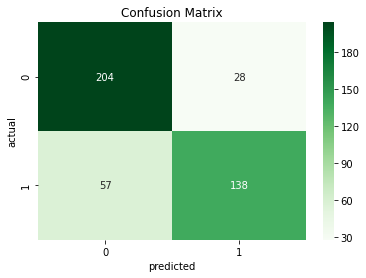

In [27]:
fsm_preds = model.predict_classes(data_array)

fn.evaluation(class_list, fsm_preds)


14/14 [==============================] - 2s 170ms/step - loss: 0.4044 - accuracy: 0.8009 - precision: 0.8313 - recall: 0.7077


[('loss', 0.4043833315372467),
 ('accuracy', 0.800936758518219),
 ('precision', 0.8313252925872803),
 ('recall', 0.7076923251152039)]

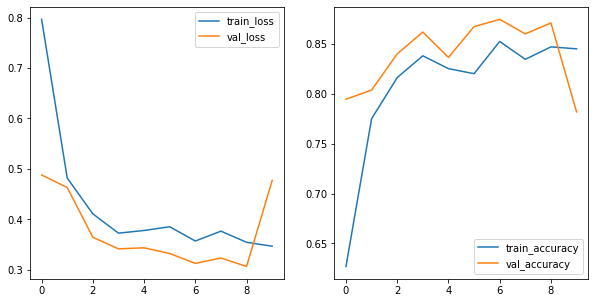

In [26]:
fsm_preds = model.predict_classes(data_array)
fn.plot_acc_loss(model, test_data, history)

## Best Model

#### Adding a shear range, zoom range, and setting horizontal flip to true

In [28]:
transfer_train_data, transfer_val_data, transfer_test_data = fn.load_final_data_generators()

Found 2568 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 427 images belonging to 2 classes.


#### Creating array to evaluate model on unseen test data

In [29]:
transfer_data_array, transfer_class_list = fn.generator_to_array(transfer_test_data)

#### Instantiating model using imagenet weights and getting the configuration

In [38]:
input_shape = Input(shape=(100,100,3))

base_model_inception_res = InceptionResNetV2(input_tensor=input_shape, include_top=False, weights='imagenet')

base_model_inception_res.trainable=False

base_model_inception_res.layers[-1].get_config()

{'name': 'conv_7b_ac',
 'trainable': False,
 'dtype': 'float32',
 'activation': 'relu'}

#### Fetching the count of all photos to include a class weight in the model

In [42]:
tr_train_files = glob.glob('../data/chest_xray/val/NORMAL/*'),  glob.glob('../data/chest_xray/val/PNEUMONIA/*')
tr_val_files = glob.glob('../data/chest_xray/val/NORMAL/*'),  glob.glob('../data/chest_xray/val/PNEUMONIA/*')
class_weight = fn.get_class_weight(tr_train_files, tr_val_files)

{0: 1.3221153846153846, 1: 0.804093567251462}


In [43]:
base_model_inception_res.trainable = True
print('Number of layers in the base model: ', len(base_model_inception_res.layers))

fine_tune = 600
for layer in base_model_inception_res.layers[: fine_tune]:
    layer.trainable = False

Number of layers in the base model:  780


#### Instantiating Sequential model for InceptionResNetV2 head and compiling with Adam optimizer

In [44]:
inception_resnet2 = Sequential([base_model_inception_res,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(100, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])

inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 15
batch_size=30

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/15
85/85 [==============================] - 45s 534ms/step - loss: 0.4714 - accuracy: 0.8071 - precision: 0.8601 - recall: 0.7670 - val_loss: 4.8326 - val_accuracy: 0.6473 - val_precision: 0.7284 - val_recall: 0.6901
Epoch 2/15
85/85 [==============================] - 46s 547ms/step - loss: 0.3149 - accuracy: 0.8761 - precision: 0.9344 - recall: 0.8380 - val_loss: 1.5854 - val_accuracy: 0.8000 - val_precision: 0.9915 - val_recall: 0.6842
Epoch 3/15
85/85 [==============================] - 49s 571ms/step - loss: 0.2820 - accuracy: 0.8909 - precision: 0.9418 - recall: 0.8582 - val_loss: 0.4893 - val_accuracy: 0.8291 - val_precision: 0.9844 - val_recall: 0.7368
Epoch 4/15
85/85 [==============================] - 48s 562ms/step - loss: 0.2609 - accuracy: 0.8898 - precision: 0.9379 - recall: 0.8603 - val_loss: 0.2356 - val_accuracy: 0.9218 - val_precision: 0.9807 - val_recall: 0.8918
Epoch 5/15
85/85 [==============================] - 48s 562ms/step - loss: 0.2431 - accuracy: 0.9132

### Evaluating the model on the unseen test data

              precision    recall  f1-score   support

      NORMAL       0.91      0.85      0.88       232
   PNEUMONIA       0.84      0.90      0.87       195

    accuracy                           0.88       427
   macro avg       0.88      0.88      0.88       427
weighted avg       0.88      0.88      0.88       427

Accurancy:  0.8758782201405152


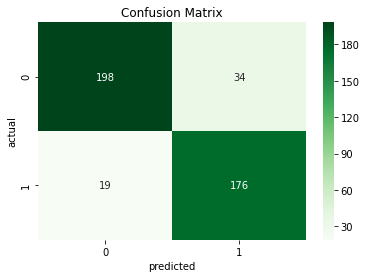

In [49]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
fn.evaluation(transfer_class_list, inception_resnet2_preds)

#### Checking model loss and accuracy curves

14/14 [==============================] - 5s 347ms/step - loss: 0.4690 - accuracy: 0.8759 - precision: 0.8381 - recall: 0.9026


[('loss', 0.468976229429245),
 ('accuracy', 0.8758782148361206),
 ('precision', 0.8380952477455139),
 ('recall', 0.9025641083717346)]

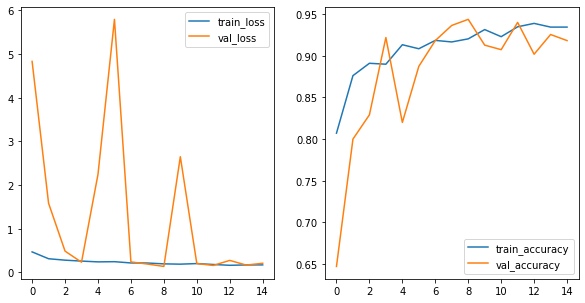

In [52]:
fn.plot_acc_loss(inception_resnet2, transfer_test_data, inception_resnet2_history)

              precision    recall  f1-score   support

      NORMAL       0.94      0.87      0.90       232
   PNEUMONIA       0.86      0.93      0.89       195

    accuracy                           0.90       427
   macro avg       0.90      0.90      0.90       427
weighted avg       0.90      0.90      0.90       427

Recall:  0.9282051282051282


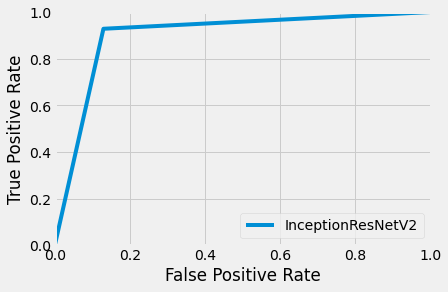

ROC-AUC: 0.899447391688771


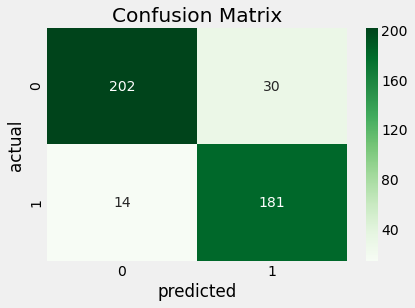

14/14 [==============================] - 6s 408ms/step - loss: 0.3017 - accuracy: 0.8970 - precision: 0.8578 - recall: 0.9282


[('loss', 0.30170679092407227),
 ('accuracy', 0.8969554901123047),
 ('precision', 0.8578199148178101),
 ('recall', 0.928205132484436)]

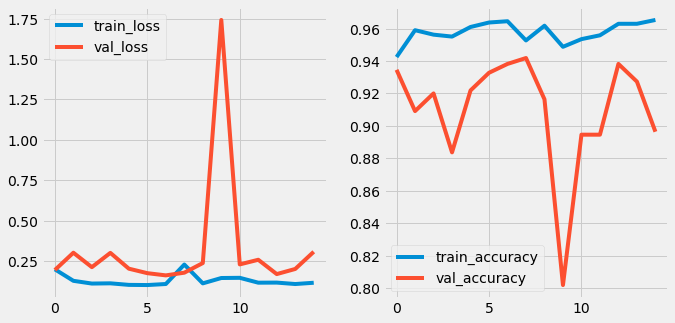

In [73]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

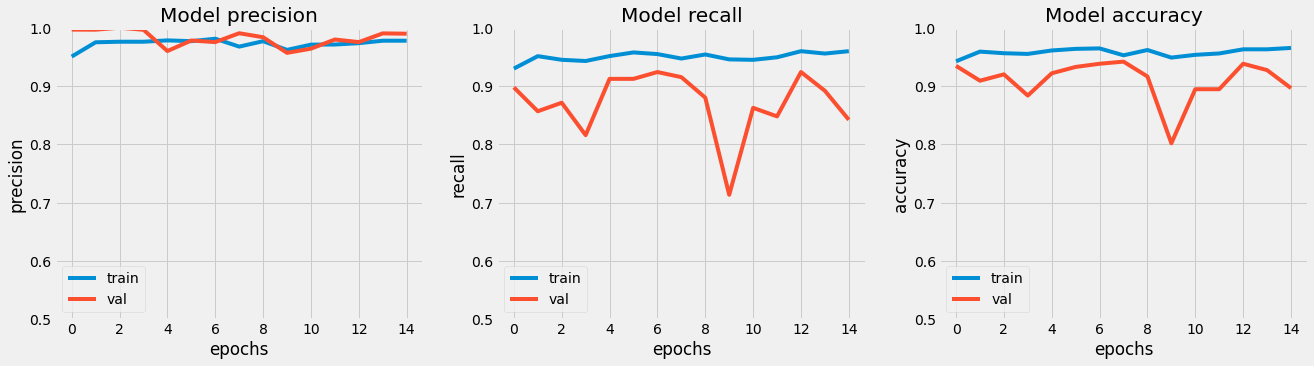

In [111]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax = ax.ravel()

for k,v in enumerate(['precision', 'recall', 'accuracy']):
    ax[k].plot(inception_resnet2_history.history[v])
    ax[k].plot(inception_resnet2_history.history['val_' + v])
    ax[k].set_title('Model {}'.format(v))
    ax[k].set_xlabel('epochs')
    ax[k].set_ylabel(v)
    ax[k].set_ylim(0.5,1)
    ax[k].legend(['train', 'val'])

In [81]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)


In [82]:
fpr, tpr, thresholds = roc_curve(class_list, fsm_preds)
rocauc = auc(fpr, tpr)

best_fpr, best_tpr, best_thresholds = roc_curve(transfer_class_list, inception_resnet2_preds)
best_rocauc = auc(best_fpr, best_tpr)

In [83]:
rocauc

0.7811965811965811

In [84]:
best_rocauc

0.899447391688771

#### Creating visuals for presentation

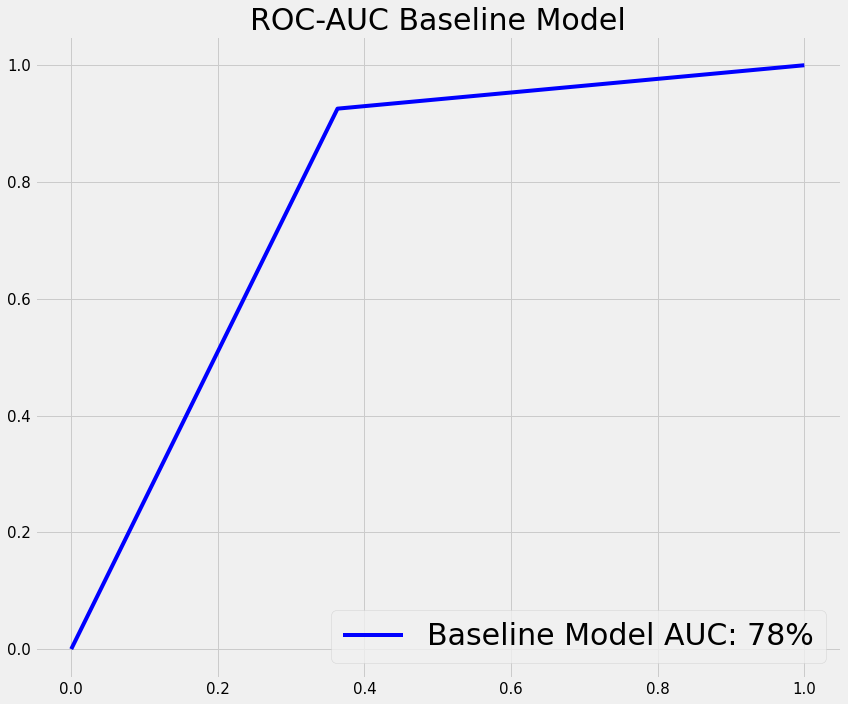

In [108]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,10))    
plt.plot(fpr, tpr, c='b', label='Baseline Model AUC: 78%', )
#plt.xlabel('False Positive Rate', fontsize=30)
#plt.ylabel('True Positive Rate', fontsize=30)
plt.title('ROC-AUC Baseline Model', fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.legend(loc='lower right', fontsize=30)
plt.savefig('roc-auc Base', transparent=True)

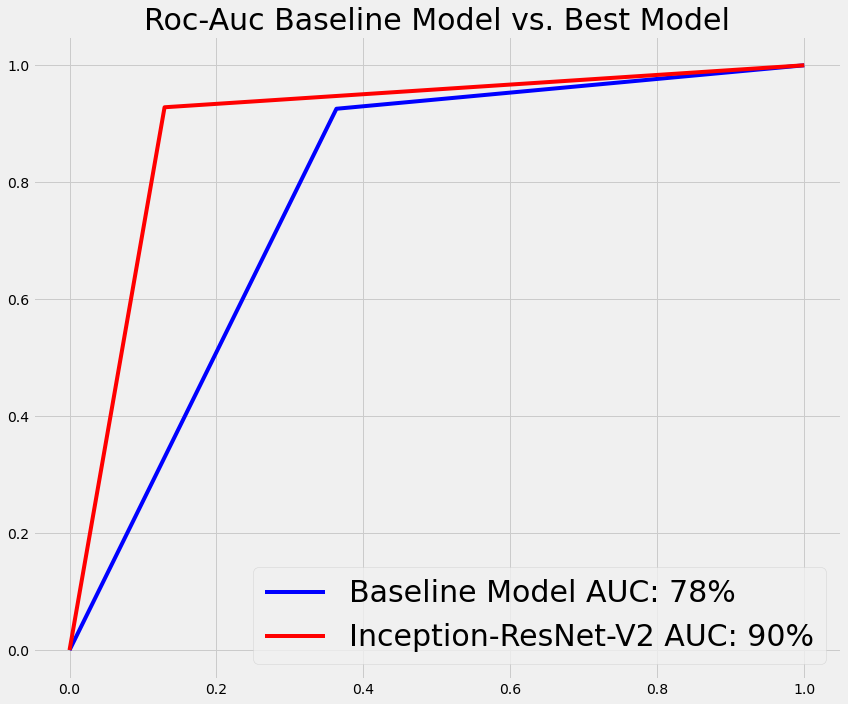

In [109]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,10))    
plt.plot(fpr, tpr, c='b', label='Baseline Model AUC: 78%')
plt.plot(best_fpr, best_tpr, c='r', label='Inception-ResNet-V2 AUC: 90%')
#plt.xlabel('False Positive Rate', fontsize=30)
#plt.ylabel('True Positive Rate', fontsize=30)
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
plt.title('Roc-Auc Baseline Model vs. Best Model', fontsize=30)
plt.tight_layout()
plt.legend(loc='lower right', fontsize=30)
plt.savefig('roc-auc', transparent=True)

#### Saving model

In [110]:
models.save_model(inception_resnet2, 'best_model')